In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../../src')
import harmoutil

from custom_callbacks import MultiAccuracyBestPerformanceCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load data
raw_data = harmoutil.load_pickled_data("../../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [3]:
# Isolate meaningful data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

chords_by_sections = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

unique_roots = sorted(list(set([harmoutil.split_root_suffix(ch)[0] for ch in chords])))
unique_suffixes = sorted(list(set([harmoutil.split_root_suffix(ch)[1] for ch in chords])))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords for note in chord_notes]
unique_notes = sorted(list(set(notes)))

print("Unique notes ({}): {}".format(len(unique_notes), unique_notes))
print("Unique chords ({}): {}".format(len(unique_chords), unique_chords))
print("Unique roots ({}): {}".format(len(unique_roots), unique_roots))
print("Unique suffixes ({}): {}".format(len(unique_suffixes), unique_suffixes))

Unique notes (13): [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique chords (193): ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', 'Dsus', 'Dsus7', 'E', 'E+', 'E+7', 'E+j7', 'E-', 'E-6', 'E-7', 'E-j7', 'E6', 'E7', 'Eb', 'Eb+', 'Eb+7

In [4]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

root_to_int = dict([(c, i) for i, c in enumerate(unique_roots)])
root_to_int['<bos>'] = len(root_to_int)

int_to_root = dict([(k, v) for v, k in root_to_int.items()])

suffix_to_int = dict([(c, i) for i, c in enumerate(unique_suffixes)])
suffix_to_int['<bos>'] = len(suffix_to_int)

int_to_suffix = dict([(k, v) for v, k in suffix_to_int.items()])


print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))
print("Root labels to integer mapping:\n {}\n".format(root_to_int))
print("Integer to root label mapping:\n {}\n".format(int_to_root))
print("Suffix label to integer mapping:\n {}\n".format(suffix_to_int))
print("Integer to suffix label mapping:\n {}\n".format(int_to_suffix))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, '<pad>': 13, -1: 12}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'A+7': 2, 'Gb': 170, 'Gb+j7': 173, 'Csus': 78, 'Ebj7': 132, 'Gj7': 186, 'Gbj7': 180, 'Bb+': 43, 'D-': 84, 'F+': 145, 'Bo': 60, 'Db+': 91, 'F7': 153, 'B-6': 37, 'Gbm7b5': 181, 'G+j7': 163, 'Dbm7b5': 101, 'Ab-6': 15, 'Fo7': 157, 'Bsus7': 63, 'Csus7': 79, 'Am7b5': 27, 'Bb-6': 47, 'A': 0, 'Bb': 42, 'E6': 120, 'Absus': 24, 'B6': 40, 'Bj7': 58, 'C-7': 70, 'A-6': 5, 'Dbsus': 104, 'Asus': 30, 'F+7': 146, 'F6': 152, 'Eb-7': 128, 'G-7': 166, 'B+j7': 35, 'Bb-j7': 49, '<bos>': 193, 'Gb-6': 175, 'Fm7b5': 155, 'Eo7': 141, 'C+j7': 67, 'Db-7': 96, 'Gb7': 179, 'Dsus': 110, 'Abj7': 20, 'Ab': 10, 'G+7': 162, 'Gm7b5': 187, 'B-j7': 39, 'Db-': 94, 'D-6': 85, 'Ab-j7': 17, 'F-': 148, 'Esus7': 143, 'Ao': 28, 'B': 32, 

In [5]:
# Refine data that will actually be used
def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False

def check_if_NC(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "NC" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
section_data = [section for section in data if not check_if_augmented_major(section)]
print("Number of sections: {}\n".format(len(section_data)))

# Remove sections that involve NC (no chord)
section_data = [section for section in section_data if not check_if_NC(section)]
print("Number of sections: {}\n".format(len(section_data)))

chords_by_sections = [get_chords_by_section(section) for section in section_data]
chords_data = [chord_info[0] for section in section_data for chord_info in section]
notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in section_data for chord_info in section]

Number of sections: 28836

Number of sections: 28416



In [6]:
# Define numerical variables

n_samples = len(chords_data)
n_chords = len(chord_to_int)
n_roots = len(root_to_int)
n_suffixes = len(suffix_to_int)
n_intervals = 12
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Number of distinct root labels", n_roots)
print("Number of distinct suffix labels:", n_suffixes)
print("Number of interval positions:", n_intervals)
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 327708
Number of distinct melody notes: 14
Number of distinct chord labels: 194
Number of distinct root labels 14
Number of distinct suffix labels: 17
Number of interval positions: 12
Maximum length of melody sequences for one chord: 115
Number of past chords given as input: 7


In [7]:
# Prepare tensor data
def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_root_sequence = context_len*['<bos>'] + [harmoutil.split_root_suffix(ch)[0] for ch in chord_seq]
    padded_suffix_sequence = context_len*['<bos>'] + [harmoutil.split_root_suffix(ch)[1] for ch in chord_seq]
    padded_chord_sequence = context_len*['<bos>'] + chord_seq
    formatted_root_sequences = [padded_root_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    formatted_suffix_sequences = [padded_suffix_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    formatted_chord_sequences = [padded_chord_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_chord_sequences, formatted_root_sequences, formatted_suffix_sequences


# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
formatted_roots_data = []
formatted_suffixes_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)[0]
    formatted_roots_data += build_input_chord_sequences(section_chords, chord_context_len)[1]
    formatted_suffixes_data += build_input_chord_sequences(section_chords, chord_context_len)[2]

input_chords_data = [ch[:-1] for ch in formatted_chords_data]
input_roots_data = [ch[:-1] for ch in formatted_roots_data]
input_suffixes_data = [ch[:-1] for ch in formatted_suffixes_data]

target_chords_data = [ch[-1] for ch in formatted_chords_data] 
target_roots_data = [ch[-1] for ch in formatted_roots_data]
target_suffixes_data = [ch[-1] for ch in formatted_suffixes_data]

print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))
print("Sample input root sequence: {}\n".format(input_roots_data[5]))
print("Sample input suffix sequence: {}\n".format(input_suffixes_data[5]))
print("Sample target root: {}\n".format(target_roots_data[5]))
print("Sample target suffix: {}\n".format(target_suffixes_data[5]))


print("Input melody: {}, Input roots & suffixes: {} {}, Target roots & suffixes: {} {}".format(len(input_melody_data), len(input_roots_data), len(input_suffixes_data), len(target_roots_data), len(target_suffixes_data)))

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

In [8]:
# Build tensors

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_roots = np.zeros((n_samples, chord_context_len, n_roots), dtype='float32')
X_intervals = np.zeros((n_samples, chord_context_len, n_intervals), dtype='float32')
Y_roots = np.zeros((n_samples, n_roots), dtype='float32')
Y_intervals = np.zeros((n_samples, n_intervals), dtype='float32')

X_labels = np.zeros((n_samples, chord_context_len, n_chords), dtype='float32')
Y_labels = np.zeros((n_samples, n_chords), dtype='float32')


for i, (input_mel, input_ch, input_rt, input_sf, target_ch, target_rt, target_sf) in enumerate(zip(input_melody_data, input_chords_data, input_roots_data, input_suffixes_data, target_chords_data, target_roots_data, target_suffixes_data)):
    Y_labels[i, chord_to_int[target_ch]] = 1
    Y_roots[i, root_to_int[target_rt]] = 1
    if not target_sf == "<bos>":
        for k, interval_presence in enumerate(harmoutil.root_position(target_sf)): 
            Y_intervals[i, k] = interval_presence
    
    for j, (chord, root, suffix) in enumerate(zip(input_ch, input_rt, input_sf)):
        X_labels[i, j, chord_to_int[chord]] = 1
        X_roots[i, j, root_to_int[root]] = 1
        if not suffix == "<bos>":
            for k, interval_presence in enumerate(harmoutil.root_position(suffix)):
                X_intervals[i, j, k] = interval_presence
    
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1

In [9]:
# Split dataset into 80%-10%-10% train-valid-test

seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_labels, Y_labels):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    
    X_labels_train, X_labels_aux = X_labels[train_index], X_labels[aux_index]
    X_roots_train, X_roots_aux = X_roots[train_index], X_roots[aux_index]
    X_intervals_train, X_intervals_aux = X_intervals[train_index], X_intervals[aux_index]
    
    Y_labels_train, Y_labels_aux = Y_labels[train_index], Y_labels[aux_index]
    Y_roots_train, Y_roots_aux = Y_roots[train_index], Y_roots[aux_index]
    Y_intervals_train, Y_intervals_aux = Y_intervals[train_index], Y_intervals[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_labels_aux, Y_labels_aux):
    X_melody_valid, X_melody_test = X_melody_aux[valid_index], X_melody_aux[test_index]
    
    X_labels_valid, X_labels_test = X_labels_aux[valid_index], X_labels_aux[test_index]
    X_roots_valid, X_roots_test = X_roots_aux[valid_index], X_roots_aux[test_index]
    X_intervals_valid, X_intervals_test = X_intervals_aux[valid_index], X_intervals_aux[test_index]
    
    Y_labels_valid, Y_labels_test = Y_labels_aux[valid_index], Y_labels_aux[test_index]
    Y_roots_valid, Y_roots_test = Y_roots_aux[valid_index], Y_roots_aux[test_index]
    Y_intervals_valid, Y_intervals_test = Y_intervals_aux[valid_index], Y_intervals_aux[test_index]

In [10]:
# Define neural net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim, return_sequences=True)(melody_gru1)
melody_gru3 = GRU(latent_dim)(melody_gru2)

roots_input = Input(shape=(chord_context_len, n_roots))
roots_gru1 = GRU(latent_dim, return_sequences=True)(roots_input)
roots_gru2 = GRU(latent_dim, return_sequences=True)(roots_gru1)
roots_gru3 = GRU(latent_dim)(roots_gru2)

intervals_input = Input(shape=(chord_context_len, n_intervals))
intervals_gru1 = GRU(latent_dim, return_sequences=True)(intervals_input)
intervals_gru2 = GRU(latent_dim, return_sequences=True)(intervals_gru1)
intervals_gru3 = GRU(latent_dim)(intervals_gru2)

concat = concatenate([melody_gru3, roots_gru3, intervals_gru3])

root_hidden1 = Dense(latent_dim, activation='relu')(concat)
root_hidden2 = Dense(latent_dim, activation='relu')(root_hidden1)
root_dense = Dense(n_roots, activation='softmax', name="root_predict")(root_hidden2)

interval_hidden1 = Dense(latent_dim, activation='relu')(concat)
interval_hidden2 = Dense(latent_dim, activation='relu')(interval_hidden1)
interval_dense = Dense(n_intervals, activation='sigmoid', name="interval_predict")(interval_hidden2)

model = Model([melody_input, roots_input, intervals_input], [root_dense, interval_dense])
model.compile(loss=['categorical_crossentropy', 'binary_crossentropy'],
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 115, 14)       0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 7, 14)         0                                            
____________________________________________________________________________________________________
input_3 (InputLayer)             (None, 7, 12)         0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 115, 128)      54912       input_1[0][0]                    
___________________________________________________________________________________________

In [11]:
# Introduce Save-Best-Performance callbacks
filepath = "RootInterval_depth3.h5"
# bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
mabpc = MultiAccuracyBestPerformanceCheckpoint(filepath, monitor=['val_root_predict_acc', 'val_interval_predict_acc'], verbose=1)

In [12]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_roots_train, X_intervals_train], [Y_roots_train, Y_intervals_train], epochs=epochs, validation_data=([X_melody_valid, X_roots_valid, X_intervals_valid], [Y_roots_valid, Y_intervals_valid]), batch_size=batch_size, callbacks=[mabpc])

Train on 262166 samples, validate on 32771 samples
Epoch 1/150
262144/262166 [============================>.] - ETA: 0s - loss: 1.8428 - root_predict_loss: 1.6269 - interval_predict_loss: 0.2160 - root_predict_acc: 0.4834 - interval_predict_acc: 0.9080
Epoch 00001: ['val_root_predict_acc', 'val_interval_predict_acc'] improved from [0.0, 0.0] => -inf to [0.58106252479508114, 0.9247046740035223] => 1.50577, saving model to RootInterval_depth3.h5
262166/262166 [==============================] - 450s - loss: 1.8428 - root_predict_loss: 1.6268 - interval_predict_loss: 0.2160 - root_predict_acc: 0.4834 - interval_predict_acc: 0.9080 - val_loss: 1.5075 - val_root_predict_loss: 1.3287 - val_interval_predict_loss: 0.1788 - val_root_predict_acc: 0.5811 - val_interval_predict_acc: 0.9247
Epoch 2/150
262144/262166 [============================>.] - ETA: 0s - loss: 1.2851 - root_predict_loss: 1.1326 - interval_predict_loss: 0.1524 - root_predict_acc: 0.6421 - interval_predict_acc: 0.9370
Epoch 0000

262166/262166 [==============================] - 440s - loss: 0.6408 - root_predict_loss: 0.5654 - interval_predict_loss: 0.0754 - root_predict_acc: 0.7989 - interval_predict_acc: 0.9670 - val_loss: 0.7219 - val_root_predict_loss: 0.6397 - val_interval_predict_loss: 0.0821 - val_root_predict_acc: 0.7810 - val_interval_predict_acc: 0.9645
Epoch 23/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.6387 - root_predict_loss: 0.5636 - interval_predict_loss: 0.0751 - root_predict_acc: 0.7995 - interval_predict_acc: 0.9671
Epoch 00023: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.75078
262166/262166 [==============================] - 440s - loss: 0.6388 - root_predict_loss: 0.5636 - interval_predict_loss: 0.0751 - root_predict_acc: 0.7995 - interval_predict_acc: 0.9671 - val_loss: 0.7191 - val_root_predict_loss: 0.6362 - val_interval_predict_loss: 0.0829 - val_root_predict_acc: 0.7830 - val_interval_predict_acc: 0.9642
Epoch 24/150
262144/26

262166/262166 [==============================] - 437s - loss: 0.6202 - root_predict_loss: 0.5476 - interval_predict_loss: 0.0726 - root_predict_acc: 0.8026 - interval_predict_acc: 0.9680 - val_loss: 0.7059 - val_root_predict_loss: 0.6257 - val_interval_predict_loss: 0.0802 - val_root_predict_acc: 0.7900 - val_interval_predict_acc: 0.9652
Epoch 35/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.6206 - root_predict_loss: 0.5478 - interval_predict_loss: 0.0729 - root_predict_acc: 0.8018 - interval_predict_acc: 0.9679
Epoch 00035: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.75517
262166/262166 [==============================] - 437s - loss: 0.6206 - root_predict_loss: 0.5478 - interval_predict_loss: 0.0728 - root_predict_acc: 0.8018 - interval_predict_acc: 0.9679 - val_loss: 0.7120 - val_root_predict_loss: 0.6325 - val_interval_predict_loss: 0.0795 - val_root_predict_acc: 0.7858 - val_interval_predict_acc: 0.9655
Epoch 36/150
262144/26

262166/262166 [==============================] - 434s - loss: 0.5858 - root_predict_loss: 0.5157 - interval_predict_loss: 0.0701 - root_predict_acc: 0.8146 - interval_predict_acc: 0.9691 - val_loss: 0.6809 - val_root_predict_loss: 0.6032 - val_interval_predict_loss: 0.0777 - val_root_predict_acc: 0.8014 - val_interval_predict_acc: 0.9667
Epoch 47/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.5746 - root_predict_loss: 0.5049 - interval_predict_loss: 0.0698 - root_predict_acc: 0.8188 - interval_predict_acc: 0.9693
Epoch 00047: ['val_root_predict_acc', 'val_interval_predict_acc'] improved from [0.80140978304170163, 0.96671081283539129] => 1.76812 to [0.80479692411155002, 0.96638531745587797] => 1.77118, saving model to RootInterval_depth3.h5
262166/262166 [==============================] - 434s - loss: 0.5747 - root_predict_loss: 0.5049 - interval_predict_loss: 0.0698 - root_predict_acc: 0.8188 - interval_predict_acc: 0.9693 - val_loss: 0.6735 - val_root_predict_l

262144/262166 [============================>.] - ETA: 0s - loss: 0.5020 - root_predict_loss: 0.4381 - interval_predict_loss: 0.0639 - root_predict_acc: 0.8475 - interval_predict_acc: 0.9721
Epoch 00069: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.79227
262166/262166 [==============================] - 436s - loss: 0.5020 - root_predict_loss: 0.4381 - interval_predict_loss: 0.0639 - root_predict_acc: 0.8474 - interval_predict_acc: 0.9721 - val_loss: 0.6571 - val_root_predict_loss: 0.5829 - val_interval_predict_loss: 0.0742 - val_root_predict_acc: 0.8229 - val_interval_predict_acc: 0.9686
Epoch 70/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.4956 - root_predict_loss: 0.4327 - interval_predict_loss: 0.0629 - root_predict_acc: 0.8493 - interval_predict_acc: 0.9725
Epoch 00070: ['val_root_predict_acc', 'val_interval_predict_acc'] improved from [0.82350248695492967, 0.96877056776755188] => 1.79227 to [0.82432638613590081, 0.96864597054

262144/262166 [============================>.] - ETA: 0s - loss: 0.3792 - root_predict_loss: 0.3234 - interval_predict_loss: 0.0558 - root_predict_acc: 0.8902 - interval_predict_acc: 0.9756
Epoch 00092: ['val_root_predict_acc', 'val_interval_predict_acc'] improved from [0.84492386561470822, 0.97053788345125114] => 1.81546 to [0.84672423789325924, 0.97078453422643995] => 1.81751, saving model to RootInterval_depth3.h5
262166/262166 [==============================] - 438s - loss: 0.3791 - root_predict_loss: 0.3234 - interval_predict_loss: 0.0558 - root_predict_acc: 0.8902 - interval_predict_acc: 0.9756 - val_loss: 0.6507 - val_root_predict_loss: 0.5801 - val_interval_predict_loss: 0.0706 - val_root_predict_acc: 0.8467 - val_interval_predict_acc: 0.9708
Epoch 93/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.3747 - root_predict_loss: 0.3188 - interval_predict_loss: 0.0560 - root_predict_acc: 0.8921 - interval_predict_acc: 0.9756
Epoch 00093: ['val_root_predict_acc'

262144/262166 [============================>.] - ETA: 0s - loss: 0.4378 - root_predict_loss: 0.3803 - interval_predict_loss: 0.0575 - root_predict_acc: 0.8691 - interval_predict_acc: 0.9749
Epoch 00117: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.81751
262166/262166 [==============================] - 438s - loss: 0.4378 - root_predict_loss: 0.3803 - interval_predict_loss: 0.0575 - root_predict_acc: 0.8691 - interval_predict_acc: 0.9749 - val_loss: 0.6508 - val_root_predict_loss: 0.5804 - val_interval_predict_loss: 0.0704 - val_root_predict_acc: 0.8347 - val_interval_predict_acc: 0.9706
Epoch 118/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.4293 - root_predict_loss: 0.3720 - interval_predict_loss: 0.0573 - root_predict_acc: 0.8720 - interval_predict_acc: 0.9750
Epoch 00118: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.81751
262166/262166 [==============================] - 438s - loss: 0.4293 - root_

262144/262166 [============================>.] - ETA: 0s - loss: 0.4803 - root_predict_loss: 0.4191 - interval_predict_loss: 0.0612 - root_predict_acc: 0.8534 - interval_predict_acc: 0.9732
Epoch 00142: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.81751
262166/262166 [==============================] - 439s - loss: 0.4803 - root_predict_loss: 0.4191 - interval_predict_loss: 0.0612 - root_predict_acc: 0.8534 - interval_predict_acc: 0.9732 - val_loss: 0.6344 - val_root_predict_loss: 0.5641 - val_interval_predict_loss: 0.0704 - val_root_predict_acc: 0.8315 - val_interval_predict_acc: 0.9704
Epoch 143/150
262144/262166 [============================>.] - ETA: 0s - loss: 0.4851 - root_predict_loss: 0.4232 - interval_predict_loss: 0.0619 - root_predict_acc: 0.8521 - interval_predict_acc: 0.9729
Epoch 00143: ['val_root_predict_acc', 'val_interval_predict_acc'] did not improve from 1.81751
262166/262166 [==============================] - 439s - loss: 0.4851 - root_

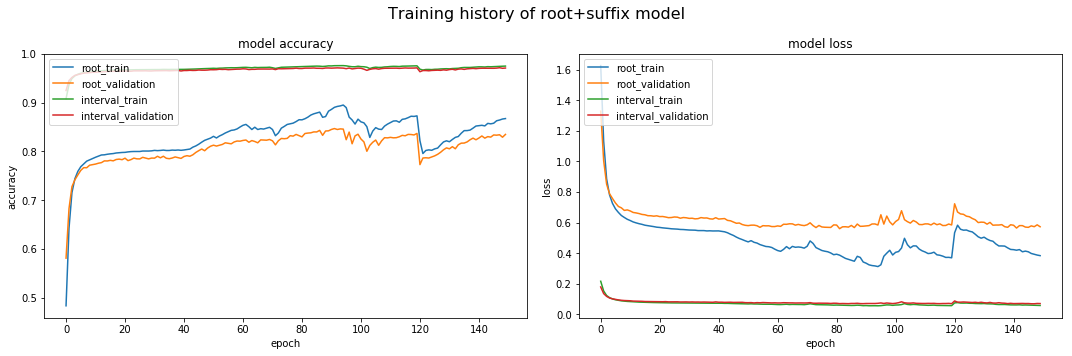

In [13]:
### Visualize model learning ###
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['root_predict_acc'])
plt.plot(history.history['val_root_predict_acc'])
plt.plot(history.history['interval_predict_acc'])
plt.plot(history.history['val_interval_predict_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'interval_train', 'interval_validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_predict_loss'])
plt.plot(history.history['val_root_predict_loss'])
plt.plot(history.history['interval_predict_loss'])
plt.plot(history.history['val_interval_predict_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['root_train', 'root_validation', 'interval_train', 'interval_validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root+suffix model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [14]:
# Load best performance model
best_model = load_model("RootInterval_depth3.h5")

In [15]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_roots_pred, Y_intervals_pred = best_model.predict([X_melody_test, X_roots_test, X_intervals_test])

# Compute accuracy and kappa score for root
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_roots_test, Y_roots_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_roots_test, Y_roots_pred)))

# Compute accuracy and kappa score for interval
print("Categorical accuracy of combined chord label prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_intervals_test, Y_intervals_pred)))
print("Kappa score of combined chord label prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_intervals_test, Y_intervals_pred)))

Categorical accuracy of combined chord label prediction: 0.8461
Kappa score of combined chord label prediction: 0.8321
Categorical accuracy of combined chord label prediction: 0.9714
TP: 122577 TN: 259426 FP: 5466 FN: 5783
Kappa score of combined chord label prediction: 0.9349


In [16]:
# Evaluate prediction in terms of pitches
def root_interval_to_pitch_tensors(rt_preds, iv_preds):
    predicted_roots = [int_to_root[np.argmax(rt)] for rt in rt_preds]
    predicted_intervals = [[round(pos) for pos in iv] for iv in iv_preds]
    pitch_chords = [harmoutil.root_intervals_to_notes(rt, iv) for (rt, iv) in zip(predicted_roots, predicted_intervals)]
    
    Y_pitches = np.zeros((rt_preds.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches
    
    
Y_rootinterval_pred_pitch = root_interval_to_pitch_tensors(Y_roots_pred, Y_intervals_pred)
Y_rootinterval_test_pitch = root_interval_to_pitch_tensors(Y_roots_test, Y_intervals_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_rootinterval_test_pitch, Y_rootinterval_pred_pitch)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_rootinterval_test_pitch, Y_rootinterval_pred_pitch)))

Categorical accuracy of combined chord pitch prediction: 0.9200
TP: 112474 TN: 249323 FP: 15569 FN: 15886
Kappa score of combined chord pitch prediction: 0.8180
